In [1]:
import os
import sys

# Add the parent directory of the current script and 'src' folder to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))



from src.model_unet_relu import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your saved data
train_data = torch.load("../data/prepared_datasets/train_celeba.pt")
train_labels = torch.load("../data/prepared_datasets/train_celeba_labels.pt")
val_data = torch.load("../data/prepared_datasets/val_celeba.pt")
val_labels = torch.load("../data/prepared_datasets/val_celeba_labels.pt")
test_data = torch.load("../data/prepared_datasets/test_celeba.pt")
test_labels = torch.load("../data/prepared_datasets/test_celeba_labels.pt")

In [3]:
train_data.shape

torch.Size([162770, 3, 64, 64])

In [4]:
train_data=train_data[:30000]
train_labels=train_labels[:30000]

In [5]:
batch_size = 32

In [6]:
def prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels, batch_size=batch_size):
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

In [7]:
# Normalize data to [0, 1] if not already done
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_data = train_data * 2 - 1
val_data = val_data * 2 - 1
test_data = test_data * 2 - 1
# Create data loaders
train_loader, val_loader, test_loader = prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [8]:
from torch.optim import Adam
from torch.optim import AdamW

image_size = 64
channels = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

#optimizer = Adam(model.parameters(), lr=5e-3)
#optimizer = AdamW(model.parameters(), lr=5e-3)
optimizer = Adam(model.parameters(), lr=1e-3)

cuda


In [9]:
timesteps = 200
betas = DiffusionSchedule.linear_beta_schedule(timesteps).clone()
diffusion_params = DiffusionSchedule.compute_diffusion_parameters(betas)

In [11]:
from torchvision.utils import save_image

epochs = 20
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        data = data.to(device)
        optimizer.zero_grad()

        #batch_size = batch["pixel_values"].shape[0]
        #batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        if data.shape[0] == batch_size:
            
            loss = p_losses(model, data, t, loss_type="huber", diffusion_params=diffusion_params)
            
            if batch_idx % 100 == 0:
                print("Loss:", loss.item())
            
            loss.backward()
            optimizer.step()

Epoch 1/20:   0%|          | 1/938 [00:00<06:45,  2.31it/s]

Loss: 0.09319501370191574


Epoch 1/20:  11%|█         | 101/938 [00:15<02:16,  6.15it/s]

Loss: 0.10931098461151123


Epoch 1/20:  21%|██▏       | 201/938 [00:31<01:52,  6.58it/s]

Loss: 0.07816736400127411


Epoch 1/20:  32%|███▏      | 301/938 [00:46<01:36,  6.60it/s]

Loss: 0.10069410502910614


Epoch 1/20:  43%|████▎     | 401/938 [01:01<01:24,  6.37it/s]

Loss: 0.0811731368303299


Epoch 1/20:  53%|█████▎    | 501/938 [01:17<01:08,  6.35it/s]

Loss: 0.13204938173294067


Epoch 1/20:  64%|██████▍   | 601/938 [01:32<00:52,  6.48it/s]

Loss: 0.12033431977033615


Epoch 1/20:  75%|███████▍  | 701/938 [01:48<00:37,  6.40it/s]

Loss: 0.06715235859155655


Epoch 1/20:  85%|████████▌ | 801/938 [02:03<00:20,  6.64it/s]

Loss: 0.07420855760574341


Epoch 1/20:  96%|█████████▌| 901/938 [02:19<00:05,  6.35it/s]

Loss: 0.045615263283252716



Epoch 2/20:   0%|          | 1/938 [00:00<02:29,  6.26it/s]]

Loss: 0.08674411475658417


Epoch 2/20:  11%|█         | 101/938 [00:15<02:12,  6.29it/s]

Loss: 0.06297728419303894


Epoch 2/20:  21%|██▏       | 201/938 [00:30<01:55,  6.38it/s]

Loss: 0.0615871325135231


Epoch 2/20:  32%|███▏      | 301/938 [00:46<01:39,  6.41it/s]

Loss: 0.06613680720329285


Epoch 2/20:  43%|████▎     | 401/938 [01:01<01:22,  6.54it/s]

Loss: 0.05574653297662735


Epoch 2/20:  53%|█████▎    | 501/938 [01:17<01:07,  6.45it/s]

Loss: 0.04103918746113777


Epoch 2/20:  64%|██████▍   | 601/938 [01:32<00:53,  6.31it/s]

Loss: 0.05707165598869324


Epoch 2/20:  75%|███████▍  | 701/938 [01:48<00:36,  6.48it/s]

Loss: 0.052868567407131195


Epoch 2/20:  85%|████████▌ | 801/938 [02:03<00:20,  6.53it/s]

Loss: 0.09557252377271652


Epoch 2/20:  96%|█████████▌| 901/938 [02:19<00:05,  6.46it/s]

Loss: 0.052547603845596313



Epoch 3/20:   0%|          | 1/938 [00:00<02:24,  6.48it/s]]

Loss: 0.04944288730621338


Epoch 3/20:  11%|█         | 101/938 [00:15<02:08,  6.53it/s]

Loss: 0.05186622589826584


Epoch 3/20:  21%|██▏       | 201/938 [00:30<01:54,  6.46it/s]

Loss: 0.06215044483542442


Epoch 3/20:  32%|███▏      | 301/938 [00:46<01:37,  6.55it/s]

Loss: 0.03435400873422623


Epoch 3/20:  43%|████▎     | 401/938 [01:01<01:20,  6.70it/s]

Loss: 0.05046100914478302


Epoch 3/20:  53%|█████▎    | 501/938 [01:17<01:08,  6.42it/s]

Loss: 0.04360991716384888


Epoch 3/20:  64%|██████▍   | 601/938 [01:32<00:50,  6.74it/s]

Loss: 0.03187240660190582


Epoch 3/20:  75%|███████▍  | 701/938 [01:47<00:35,  6.63it/s]

Loss: 0.056624434888362885


Epoch 3/20:  85%|████████▌ | 801/938 [02:02<00:21,  6.42it/s]

Loss: 0.06153086572885513


Epoch 3/20:  96%|█████████▌| 901/938 [02:17<00:05,  6.72it/s]

Loss: 0.04977744445204735



Epoch 4/20:   0%|          | 1/938 [00:00<02:17,  6.80it/s]]

Loss: 0.060886889696121216


Epoch 4/20:  11%|█         | 101/938 [00:15<02:05,  6.65it/s]

Loss: 0.060439251363277435


Epoch 4/20:  21%|██▏       | 201/938 [00:30<01:55,  6.38it/s]

Loss: 0.047092996537685394


Epoch 4/20:  32%|███▏      | 301/938 [00:46<01:34,  6.77it/s]

Loss: 0.05976645648479462


Epoch 4/20:  43%|████▎     | 401/938 [01:01<01:19,  6.73it/s]

Loss: 0.049167171120643616


Epoch 4/20:  53%|█████▎    | 501/938 [01:16<01:09,  6.30it/s]

Loss: 0.03822336718440056


Epoch 4/20:  64%|██████▍   | 601/938 [01:32<00:51,  6.51it/s]

Loss: 0.04036688804626465


Epoch 4/20:  75%|███████▍  | 701/938 [01:47<00:37,  6.33it/s]

Loss: 0.04569385200738907


Epoch 4/20:  85%|████████▌ | 801/938 [02:02<00:21,  6.37it/s]

Loss: 0.04049006849527359


Epoch 4/20:  96%|█████████▌| 901/938 [02:18<00:05,  6.21it/s]

Loss: 0.05106022208929062



Epoch 5/20:   0%|          | 1/938 [00:00<02:24,  6.49it/s]]

Loss: 0.04357536882162094


Epoch 5/20:  11%|█         | 101/938 [00:15<02:06,  6.63it/s]

Loss: 0.05581648275256157


Epoch 5/20:  21%|██▏       | 201/938 [00:30<01:52,  6.54it/s]

Loss: 0.04333146661520004


Epoch 5/20:  32%|███▏      | 301/938 [00:46<01:36,  6.58it/s]

Loss: 0.04515557736158371


Epoch 5/20:  43%|████▎     | 401/938 [01:01<01:24,  6.37it/s]

Loss: 0.06846068799495697


Epoch 5/20:  53%|█████▎    | 501/938 [01:17<01:06,  6.53it/s]

Loss: 0.041657865047454834


Epoch 5/20:  64%|██████▍   | 601/938 [01:32<00:52,  6.41it/s]

Loss: 0.02961212396621704


Epoch 5/20:  75%|███████▍  | 701/938 [01:48<00:37,  6.34it/s]

Loss: 0.04970933124423027


Epoch 5/20:  85%|████████▌ | 801/938 [02:03<00:20,  6.54it/s]

Loss: 0.04151057451963425


Epoch 5/20:  96%|█████████▌| 901/938 [02:18<00:05,  6.51it/s]

Loss: 0.046362973749637604



Epoch 6/20:   0%|          | 1/938 [00:00<02:29,  6.29it/s]]

Loss: 0.032374437898397446


Epoch 6/20:  11%|█         | 101/938 [00:15<02:08,  6.53it/s]

Loss: 0.04477561637759209


Epoch 6/20:  21%|██▏       | 201/938 [00:31<01:53,  6.52it/s]

Loss: 0.04041803255677223


Epoch 6/20:  32%|███▏      | 301/938 [00:46<01:40,  6.34it/s]

Loss: 0.023197170346975327


Epoch 6/20:  43%|████▎     | 401/938 [01:01<01:23,  6.42it/s]

Loss: 0.027285834774374962


Epoch 6/20:  53%|█████▎    | 501/938 [01:17<01:04,  6.75it/s]

Loss: 0.03124217316508293


Epoch 6/20:  64%|██████▍   | 601/938 [01:32<00:53,  6.31it/s]

Loss: 0.04442819580435753


Epoch 6/20:  75%|███████▍  | 701/938 [01:48<00:36,  6.50it/s]

Loss: 0.026392649859189987


Epoch 6/20:  85%|████████▌ | 801/938 [02:03<00:20,  6.72it/s]

Loss: 47.73895263671875


Epoch 6/20:  96%|█████████▌| 901/938 [02:18<00:05,  6.28it/s]

Loss: 0.4690583348274231



Epoch 7/20:   0%|          | 1/938 [00:00<02:22,  6.58it/s]]

Loss: 0.4209238886833191


Epoch 7/20:  11%|█         | 101/938 [00:15<02:10,  6.41it/s]

Loss: 0.37349075078964233


Epoch 7/20:  21%|██▏       | 201/938 [00:30<01:53,  6.50it/s]

Loss: 0.3535815179347992


Epoch 7/20:  32%|███▏      | 301/938 [00:46<01:38,  6.50it/s]

Loss: 0.3484227657318115


Epoch 7/20:  43%|████▎     | 401/938 [01:01<01:21,  6.61it/s]

Loss: 0.3275272846221924


Epoch 7/20:  53%|█████▎    | 501/938 [01:16<01:09,  6.30it/s]

Loss: 0.33394140005111694


Epoch 7/20:  64%|██████▍   | 601/938 [01:32<00:51,  6.60it/s]

Loss: 0.2837259769439697


Epoch 7/20:  75%|███████▍  | 701/938 [01:47<00:36,  6.50it/s]

Loss: 0.2755810022354126


Epoch 7/20:  85%|████████▌ | 801/938 [02:03<00:21,  6.45it/s]

Loss: 0.26537662744522095


Epoch 7/20:  96%|█████████▌| 901/938 [02:18<00:05,  6.45it/s]

Loss: 0.2625480592250824



Epoch 8/20:   0%|          | 1/938 [00:00<02:32,  6.13it/s]]

Loss: 0.25019606947898865


Epoch 8/20:  11%|█         | 101/938 [00:15<02:12,  6.33it/s]

Loss: 0.2462064027786255


Epoch 8/20:  21%|██▏       | 201/938 [00:30<01:52,  6.53it/s]

Loss: 0.25236251950263977


Epoch 8/20:  32%|███▏      | 301/938 [00:46<01:36,  6.61it/s]

Loss: 0.20277807116508484


Epoch 8/20:  43%|████▎     | 401/938 [01:01<01:21,  6.58it/s]

Loss: 0.23173943161964417


Epoch 8/20:  53%|█████▎    | 501/938 [01:16<01:06,  6.62it/s]

Loss: 0.18758557736873627


Epoch 8/20:  64%|██████▍   | 601/938 [01:31<00:49,  6.80it/s]

Loss: 0.1720556914806366


Epoch 8/20:  75%|███████▍  | 701/938 [01:46<00:35,  6.71it/s]

Loss: 0.15449950098991394


Epoch 8/20:  85%|████████▌ | 801/938 [02:02<00:20,  6.60it/s]

Loss: 0.14534705877304077


Epoch 8/20:  96%|█████████▌| 901/938 [02:17<00:05,  6.55it/s]

Loss: 0.14022284746170044



Epoch 9/20:   0%|          | 1/938 [00:00<02:17,  6.82it/s]]

Loss: 0.11951371282339096


Epoch 9/20:  11%|█         | 101/938 [00:15<02:09,  6.46it/s]

Loss: 0.16785717010498047


Epoch 9/20:  21%|██▏       | 201/938 [00:30<01:50,  6.64it/s]

Loss: 0.1281886100769043


Epoch 9/20:  32%|███▏      | 301/938 [00:45<01:38,  6.48it/s]

Loss: 0.14018258452415466


Epoch 9/20:  43%|████▎     | 401/938 [01:00<01:23,  6.43it/s]

Loss: 0.10845497250556946


Epoch 9/20:  53%|█████▎    | 501/938 [01:16<01:04,  6.76it/s]

Loss: 0.11401164531707764


Epoch 9/20:  64%|██████▍   | 601/938 [01:31<00:53,  6.34it/s]

Loss: 0.11192260682582855


Epoch 9/20:  75%|███████▍  | 701/938 [01:46<00:36,  6.58it/s]

Loss: 0.10482929646968842


Epoch 9/20:  85%|████████▌ | 801/938 [02:01<00:20,  6.85it/s]

Loss: 0.12613272666931152


Epoch 9/20:  96%|█████████▌| 901/938 [02:16<00:05,  6.50it/s]

Loss: 0.1223556324839592



Epoch 10/20:   0%|          | 1/938 [00:00<02:21,  6.63it/s]

Loss: 0.0933929979801178


Epoch 10/20:  11%|█         | 101/938 [00:15<02:13,  6.29it/s]

Loss: 0.09608563780784607


Epoch 10/20:  21%|██▏       | 201/938 [00:30<01:53,  6.50it/s]

Loss: 0.10689719766378403


Epoch 10/20:  32%|███▏      | 301/938 [00:46<01:39,  6.42it/s]

Loss: 0.1007622629404068


Epoch 10/20:  43%|████▎     | 401/938 [01:01<01:19,  6.80it/s]

Loss: 0.058782629668712616


Epoch 10/20:  53%|█████▎    | 501/938 [01:16<01:06,  6.59it/s]

Loss: 0.07750845700502396


Epoch 10/20:  64%|██████▍   | 601/938 [01:31<00:55,  6.09it/s]

Loss: 0.08206366002559662


Epoch 10/20:  75%|███████▍  | 701/938 [01:47<00:36,  6.52it/s]

Loss: 0.0747736394405365


Epoch 10/20:  85%|████████▌ | 801/938 [02:03<00:21,  6.42it/s]

Loss: 0.06989903748035431


Epoch 10/20:  96%|█████████▌| 901/938 [02:18<00:05,  6.56it/s]

Loss: 0.0976799950003624



Epoch 11/20:   0%|          | 1/938 [00:00<02:19,  6.69it/s]]

Loss: 0.08661656826734543


Epoch 11/20:  11%|█         | 101/938 [00:15<02:10,  6.40it/s]

Loss: 0.07704436033964157


Epoch 11/20:  21%|██▏       | 201/938 [00:30<01:54,  6.46it/s]

Loss: 0.07334133982658386


Epoch 11/20:  32%|███▏      | 301/938 [00:45<01:38,  6.44it/s]

Loss: 0.04764425382018089


Epoch 11/20:  43%|████▎     | 401/938 [01:01<01:21,  6.63it/s]

Loss: 0.0747368335723877


Epoch 11/20:  53%|█████▎    | 501/938 [01:16<01:07,  6.51it/s]

Loss: 0.045580726116895676


Epoch 11/20:  64%|██████▍   | 601/938 [01:31<00:50,  6.68it/s]

Loss: 0.0533977746963501


Epoch 11/20:  75%|███████▍  | 701/938 [01:46<00:36,  6.48it/s]

Loss: 0.05139560252428055


Epoch 11/20:  85%|████████▌ | 801/938 [02:02<00:20,  6.55it/s]

Loss: 0.09353281557559967


Epoch 11/20:  96%|█████████▌| 901/938 [02:17<00:05,  6.70it/s]

Loss: 0.04953690618276596



Epoch 12/20:   0%|          | 1/938 [00:00<02:31,  6.18it/s]]

Loss: 0.0580839142203331


Epoch 12/20:  11%|█         | 101/938 [00:15<02:07,  6.54it/s]

Loss: 0.05648575350642204


Epoch 12/20:  21%|██▏       | 201/938 [00:31<01:50,  6.66it/s]

Loss: 0.04264930635690689


Epoch 12/20:  32%|███▏      | 301/938 [00:46<01:36,  6.60it/s]

Loss: 0.057368457317352295


Epoch 12/20:  43%|████▎     | 401/938 [01:01<01:20,  6.71it/s]

Loss: 0.04898294061422348


Epoch 12/20:  53%|█████▎    | 501/938 [01:17<01:05,  6.71it/s]

Loss: 0.06443526595830917


Epoch 12/20:  64%|██████▍   | 601/938 [01:32<00:52,  6.47it/s]

Loss: 0.044915489852428436


Epoch 12/20:  75%|███████▍  | 701/938 [01:47<00:36,  6.47it/s]

Loss: 0.05753258988261223


Epoch 12/20:  85%|████████▌ | 801/938 [02:02<00:20,  6.63it/s]

Loss: 0.06990550458431244


Epoch 12/20:  96%|█████████▌| 901/938 [02:17<00:05,  6.66it/s]

Loss: 0.05047592520713806



Epoch 13/20:   0%|          | 1/938 [00:00<02:16,  6.84it/s]]

Loss: 0.03564795106649399


Epoch 13/20:  11%|█         | 101/938 [00:15<02:07,  6.56it/s]

Loss: 0.06498423218727112


Epoch 13/20:  21%|██▏       | 201/938 [00:30<01:55,  6.41it/s]

Loss: 0.0731060802936554


Epoch 13/20:  32%|███▏      | 301/938 [00:46<01:39,  6.43it/s]

Loss: 0.08239569514989853


Epoch 13/20:  43%|████▎     | 401/938 [01:01<01:22,  6.54it/s]

Loss: 0.05983620882034302


Epoch 13/20:  53%|█████▎    | 501/938 [01:16<01:06,  6.58it/s]

Loss: 0.05606864392757416


Epoch 13/20:  64%|██████▍   | 601/938 [01:31<00:50,  6.64it/s]

Loss: 0.06290610134601593


Epoch 13/20:  75%|███████▍  | 701/938 [01:46<00:35,  6.59it/s]

Loss: 0.055943578481674194


Epoch 13/20:  85%|████████▌ | 801/938 [02:01<00:20,  6.58it/s]

Loss: 0.06407362222671509


Epoch 13/20:  96%|█████████▌| 901/938 [02:17<00:05,  6.75it/s]

Loss: 0.04300681874155998



Epoch 14/20:   0%|          | 1/938 [00:00<02:18,  6.79it/s]]

Loss: 0.04561769589781761


Epoch 14/20:  11%|█         | 101/938 [00:14<02:08,  6.51it/s]

Loss: 43.53141784667969


Epoch 14/20:  21%|██▏       | 201/938 [00:30<01:49,  6.72it/s]

Loss: 0.4299062192440033


Epoch 14/20:  32%|███▏      | 301/938 [00:45<01:36,  6.62it/s]

Loss: 0.3508912920951843


Epoch 14/20:  43%|████▎     | 401/938 [01:00<01:21,  6.60it/s]

Loss: 0.2773791253566742


Epoch 14/20:  53%|█████▎    | 501/938 [01:15<01:04,  6.78it/s]

Loss: 0.24818281829357147


Epoch 14/20:  64%|██████▍   | 601/938 [01:30<00:49,  6.75it/s]

Loss: 0.2587268352508545


Epoch 14/20:  75%|███████▍  | 701/938 [01:45<00:37,  6.32it/s]

Loss: 0.18681472539901733


Epoch 14/20:  85%|████████▌ | 801/938 [02:00<00:20,  6.72it/s]

Loss: 0.19509629905223846


Epoch 14/20:  96%|█████████▌| 901/938 [02:16<00:05,  6.55it/s]

Loss: 0.15569472312927246



Epoch 15/20:   0%|          | 1/938 [00:00<02:25,  6.44it/s]]

Loss: 0.16647204756736755


Epoch 15/20:  11%|█         | 101/938 [00:15<02:03,  6.79it/s]

Loss: 0.11395825445652008


Epoch 15/20:  21%|██▏       | 201/938 [00:30<01:47,  6.86it/s]

Loss: 0.13084840774536133


Epoch 15/20:  32%|███▏      | 301/938 [00:45<01:34,  6.75it/s]

Loss: 0.1142670139670372


Epoch 15/20:  43%|████▎     | 401/938 [01:00<01:21,  6.61it/s]

Loss: 0.16463956236839294


Epoch 15/20:  53%|█████▎    | 501/938 [01:15<01:06,  6.53it/s]

Loss: 0.14572232961654663


Epoch 15/20:  64%|██████▍   | 601/938 [01:30<00:51,  6.50it/s]

Loss: 0.10863439738750458


Epoch 15/20:  75%|███████▍  | 701/938 [01:45<00:36,  6.47it/s]

Loss: 0.10987874865531921


Epoch 15/20:  85%|████████▌ | 801/938 [02:00<00:19,  7.00it/s]

Loss: 0.13978207111358643


Epoch 15/20:  96%|█████████▌| 901/938 [02:15<00:05,  6.57it/s]

Loss: 0.1258009374141693



Epoch 16/20:   0%|          | 1/938 [00:00<02:14,  6.96it/s]]

Loss: 0.09106603264808655


Epoch 16/20:  11%|█         | 101/938 [00:15<02:03,  6.79it/s]

Loss: 0.1047062799334526


Epoch 16/20:  21%|██▏       | 201/938 [00:29<01:48,  6.80it/s]

Loss: 0.0984906405210495


Epoch 16/20:  32%|███▏      | 301/938 [00:44<01:33,  6.79it/s]

Loss: 0.12311893701553345


Epoch 16/20:  43%|████▎     | 401/938 [00:59<01:21,  6.61it/s]

Loss: 0.1046714037656784


Epoch 16/20:  53%|█████▎    | 501/938 [01:14<01:05,  6.65it/s]

Loss: 0.11412104219198227


Epoch 16/20:  64%|██████▍   | 601/938 [01:30<00:49,  6.78it/s]

Loss: 0.12238331884145737


Epoch 16/20:  75%|███████▍  | 701/938 [01:44<00:35,  6.76it/s]

Loss: 0.09827699512243271


Epoch 16/20:  85%|████████▌ | 801/938 [01:59<00:20,  6.64it/s]

Loss: 0.07976964116096497


Epoch 16/20:  96%|█████████▌| 901/938 [02:15<00:05,  6.26it/s]

Loss: 0.07488992810249329



Epoch 17/20:   0%|          | 1/938 [00:00<02:21,  6.62it/s]]

Loss: 0.07854845374822617


Epoch 17/20:  11%|█         | 101/938 [00:15<02:07,  6.57it/s]

Loss: 0.07385469228029251


Epoch 17/20:  21%|██▏       | 201/938 [00:30<01:50,  6.68it/s]

Loss: 0.08717447519302368


Epoch 17/20:  32%|███▏      | 301/938 [00:45<01:36,  6.57it/s]

Loss: 0.10911716520786285


Epoch 17/20:  43%|████▎     | 401/938 [01:00<01:17,  6.90it/s]

Loss: 0.10105367749929428


Epoch 17/20:  53%|█████▎    | 501/938 [01:15<01:07,  6.49it/s]

Loss: 0.08115887641906738


Epoch 17/20:  64%|██████▍   | 601/938 [01:31<00:50,  6.68it/s]

Loss: 0.09145109355449677


Epoch 17/20:  75%|███████▍  | 701/938 [01:46<00:36,  6.44it/s]

Loss: 0.07193212956190109


Epoch 17/20:  85%|████████▌ | 801/938 [02:01<00:21,  6.47it/s]

Loss: 0.06667632609605789


Epoch 17/20:  96%|█████████▌| 901/938 [02:16<00:05,  6.82it/s]

Loss: 0.08084975183010101



Epoch 18/20:   0%|          | 1/938 [00:00<02:18,  6.75it/s]]

Loss: 0.07839428633451462


Epoch 18/20:  11%|█         | 101/938 [00:15<02:03,  6.76it/s]

Loss: 0.0618453323841095


Epoch 18/20:  21%|██▏       | 201/938 [00:30<01:54,  6.46it/s]

Loss: 0.06291891634464264


Epoch 18/20:  32%|███▏      | 301/938 [00:45<01:38,  6.50it/s]

Loss: 0.061346910893917084


Epoch 18/20:  43%|████▎     | 401/938 [01:01<01:20,  6.68it/s]

Loss: 0.06771919131278992


Epoch 18/20:  53%|█████▎    | 501/938 [01:16<01:07,  6.51it/s]

Loss: 0.06806990504264832


Epoch 18/20:  64%|██████▍   | 601/938 [01:31<00:48,  6.90it/s]

Loss: 0.059903647750616074


Epoch 18/20:  75%|███████▍  | 701/938 [01:46<00:36,  6.45it/s]

Loss: 0.04982191324234009


Epoch 18/20:  85%|████████▌ | 801/938 [02:01<00:21,  6.47it/s]

Loss: 0.07321802526712418


Epoch 18/20:  96%|█████████▌| 901/938 [02:16<00:05,  6.37it/s]

Loss: 0.07295501232147217



Epoch 19/20:   0%|          | 1/938 [00:00<02:30,  6.23it/s]]

Loss: 0.07333596050739288


Epoch 19/20:  11%|█         | 101/938 [00:15<02:07,  6.57it/s]

Loss: 0.07886561006307602


Epoch 19/20:  21%|██▏       | 201/938 [00:30<01:53,  6.47it/s]

Loss: 0.05772772431373596


Epoch 19/20:  32%|███▏      | 301/938 [00:45<01:36,  6.62it/s]

Loss: 0.04716099053621292


Epoch 19/20:  43%|████▎     | 401/938 [01:00<01:19,  6.79it/s]

Loss: 0.06011977791786194


Epoch 19/20:  53%|█████▎    | 501/938 [01:15<01:03,  6.88it/s]

Loss: 0.05208117887377739


Epoch 19/20:  64%|██████▍   | 601/938 [01:30<00:53,  6.31it/s]

Loss: 0.036826469004154205


Epoch 19/20:  75%|███████▍  | 701/938 [01:45<00:35,  6.73it/s]

Loss: 0.05048472806811333


Epoch 19/20:  85%|████████▌ | 801/938 [02:00<00:20,  6.70it/s]

Loss: 0.04953509569168091


Epoch 19/20:  96%|█████████▌| 901/938 [02:16<00:05,  6.65it/s]

Loss: 0.08020631968975067



Epoch 20/20:   0%|          | 1/938 [00:00<02:24,  6.47it/s]]

Loss: 0.06662768125534058


Epoch 20/20:  11%|█         | 101/938 [00:15<02:11,  6.35it/s]

Loss: 0.06254112720489502


Epoch 20/20:  21%|██▏       | 201/938 [00:30<01:55,  6.41it/s]

Loss: 0.06940644979476929


Epoch 20/20:  32%|███▏      | 301/938 [00:46<01:36,  6.57it/s]

Loss: 0.057479970157146454


Epoch 20/20:  43%|████▎     | 401/938 [01:01<01:19,  6.75it/s]

Loss: 0.034983355551958084


Epoch 20/20:  53%|█████▎    | 501/938 [01:16<01:09,  6.32it/s]

Loss: 0.05850663781166077


Epoch 20/20:  64%|██████▍   | 601/938 [01:31<00:52,  6.43it/s]

Loss: 0.05328212305903435


Epoch 20/20:  75%|███████▍  | 701/938 [01:47<00:37,  6.38it/s]

Loss: 0.05434560030698776


Epoch 20/20:  85%|████████▌ | 801/938 [02:02<00:20,  6.80it/s]

Loss: 0.0585409477353096


Epoch 20/20:  96%|█████████▌| 901/938 [02:17<00:05,  6.53it/s]

Loss: 0.039072439074516296



poch 20/20: 100%|██████████| 938/938 [02:23<00:00,  6.55it/s]

In [12]:
torch.save({
    'epoch': epochs,
    'batch_size':batch_size,
    'model_state_dict': model.state_dict(),
}, 'model_relu_celeba.pth')

In [13]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
checkpoint = torch.load('model_relu_celeba.pth')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)

model = model.to(device)

In [14]:
print(image_size,channels)
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels, diffusion_params=diffusion_params)

64 3



ampling loop time step: 100%|██████████| 200/200 [00:10<00:00, 19.93it/s]

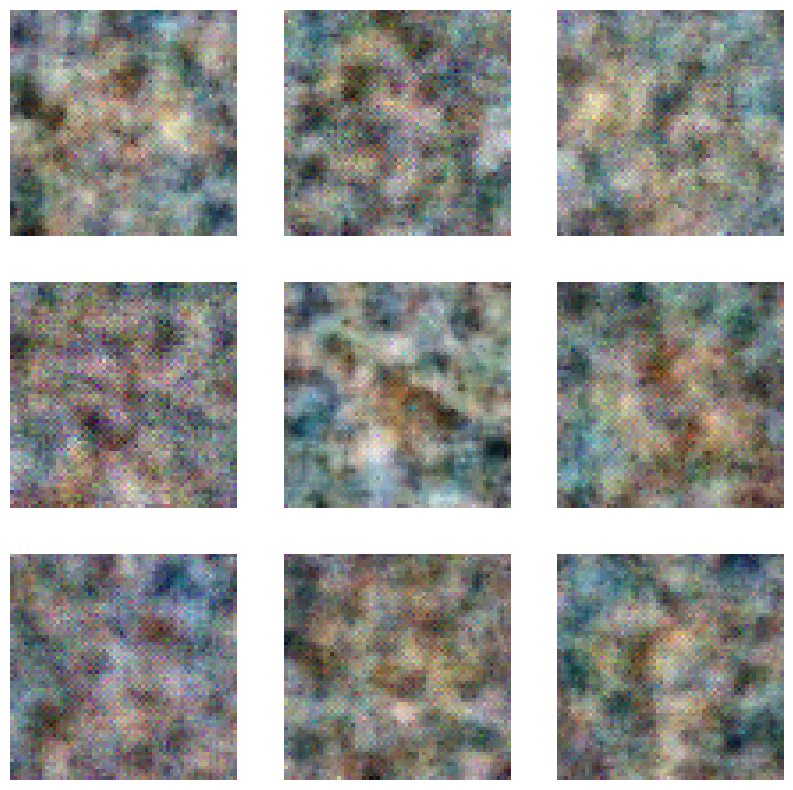

In [15]:
import numpy as np
num_images = 9

plt.figure(figsize=(10, 10)) 

for i in range(num_images):
    img = samples[-1][i] 
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    img = (img - img.min()) / (img.max() - img.min()) 

    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
    plt.imshow(img)
    plt.axis('off')  # Hide axis

    # Save the individual image with a unique name
    #plt.imsave(f"saved_image{i+1}.png", img)

#plt.tight_layout()
plt.show()